# Tutorial 3: Text classification with movie reviews

So far, we've built basic intuition around ML, and how to build a simple multi-layer classifier. In the previous tutorial, we dove deeper into the use case for deep learning as a tool. We showed that it is possible to use more advanced, manually created features (feature crosses), as well as use deeper neural networks to learn representations from data automatically. We also played around with the [TensorFlow Playground](http://playground.tensorflow.org/), a great tool for reviewing the concepts of datasets, loss functions, training and testing data, and learning.

Until now we've worked with toy datasets (Iris flowers, or collections of points). In this tutorial, we'll use a real, popular text dataset -- **the IMDb sentiment dataset** -- and use it to build a text sentiment classfier.

With this tutorial, we'll begin a series of explorations on practical problems with ML applications, and approach them as an ML practitioner would. The ground we cover here, especially around feature extraction and dataset preparation considerations, will also set us up nicely to explore ML Fairness-related considerations in subsequent tutorials.

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np

%load_ext autoreload
%autoreload 1
%aimport tutorial.datasets

## Gathering data

The data for this tutorial comes from the [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/), which is a dataset for binary **sentiment classification** containing 25K highly polar movie reviews for training and 25K for testing. This dataset has been used extensively in literature since 2011, finding its way into state-of-the-art natural language processing methods.

We'll use the IMDb dataset because of the relatively large number of examples and its **well-balanced** nature (roughly even number of positive and negative examples). Well-balanced datasets make it easier for machine learning models generalize well to producing both positive and negative decisions, so they're a good starter for our foray into text models. Some datasets have an extremely low number of positive examples, making learning more challenging (something we'll explore later).

For this tutorial, we already have a helper method to import the movie review data for analysis and modeling, assuming the [dataset TAR file](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) has been downloaded and uncompressed.

In [2]:
data, labels = tutorial.datasets.load_imdb_dataset("../data/raw", seed=123)

## Exploring data

Before we even begin to build and train a model, we'll spend a little time exploring and understanding the data we're dealing with. This almost always helps inform the modeling approach to take, and helps determine things like how much data to use for training, or how many computational resources we'll need (the more complex a model's architecture, the more expensive it is to train).

Let's look at a training example and its corresponding label.

In [3]:
data['train'][1]

'The long list of "big" names in this flick (including the ubiquitous John Mills) didn\'t bowl me over to the extent that I couldn\'t judge the film on its actual merits. It is FULL of stereotypes, caricatures, and standard, set scenes, from the humble air-ace hero to the loud-mouthed yank flyer. The music track was such that at one point, about an hour before the end, I thought the film was over: loud, rising crescendo, grand flourish and finish then silence, but then the movie continued! I found no real storyline, haphazard writing, but smartly-pressed uniforms and the pretty Jean Simmons (pre-nose job) with a rousing little ditty. I cannot say that this picture has any of the ingredients which make a film great. I found it maudlin, mawkish and minor.'

Clearly, this is a negative review of the film, which is reflected in its label (0, corresponding to negative sentiment).

In [4]:
labels['train'][1]

0

On the other hand, here's a review with positive sentiment, which we can see in its corresponding label.

In [5]:
data['train'][2]

'Bette Midler showcases her talents and beauty in "Diva Las Vegas". I am thrilled that I taped it and I am able to view whenever I want to. She possesses what it takes to keep an audience in captivity. Her voice is as beautiful as ever and will truly impress you. The highlight of the show was her singing "Stay With Me" from her 1979 movie "The Rose". You can feel the emotion in the song and will end up having goose bumps. The show will leave you with the urge to go out and either rent a Bette Midler movie or go to the nearest music store and purchase one of Bette Midler\'s albums.'

In [6]:
labels['train'][2]

1

Let's compute some simple statistics for our training data.

In [7]:
print("Number of samples: {}".format(len(data['train'])))
print("Number of samples by class: positive {}, negative {}".format(
    len([y for y in labels['train'] if y == 0]), len([y for y in labels['train'] if y == 1])))
num_words = [len(s.split()) for s in data['train']]
print("Median number of words per sample: {}".format(np.median(num_words)))

Number of samples: 25000
Number of samples by class: positive 12500, negative 12500
Median number of words per sample: 174.0


The median number of words per sample is around 174, which is reasonably large. The number of words per sample is an important metric to determine what kind of learning method will work well on data. In general, if there are a relatively large number of words per sample, then we can use simpler learning methods that treat text as a "bag of words" (more on that in the next section). These are called **n-gram models**. If there are fewer number of words per sample, we might need to use more advanced **sequence models**, that better preserve and use ordering information between words.

Developing intuition for exactly how many words is "large enough" or "small enough" takes some trial-and-error and experimentation. In this tutorial we'll simply go with the choice of an n-gram model and train it from start to finish. In later tutorials, we might contrast this with a sequence model, which requires a different approach to preparing data and building a model.

## Training an n-gram model: preparing the data

Before anything, we need to make sure our dataset is set up correctly. We would like to **shuffle** the dataset to remove any effects associated with the order in which the dataset was gathered. Good practice also dictates extracting out a **validation set** from the training data. The validation data is useful as a "practice test set" during model training, so that we can adjust the parameters of the model (like how long to train, how quickly to adjust the model weights, etc).

The test set is kept distinct and is only used to verify the final results from a trained model.

Since the utility function that loaded the dataset already took care of shuffling the data, we can simply pick the first 5000 (20% of data) for the validation set.

In [8]:
data['validate'] = data['train'][:5000]
labels['validate'] = labels['train'][:5000]
data['train'] = data['train'][5000:]
labels['train'] = labels['train'][5000:]

## Training an n-gram model: extracting features

As we know, before training a model we need to identify the **input features** to use. ML models take a fixed size  sequence of numbers as input (in the Iris dataset, it was a sequence of petal and sepal measurements; in the "points" dataset from last tutorial, it was the `x` and `y` coordinates of the points and various cross-features).

In this case, though, instead of fixed size numerical sequences, we have raw texts of varying lengths. To convert data to these fixed size sequences, we'll do two steps:

1. **Tokenization**: dividing each text into smaller _tokens_ or sub-texts. The most common approach is to use individual words as tokens.
2. **Vectorization**: using the tokens derived from the first step to create a good numerical sequence or **vector** representation of the text.

Let's walk through a specific example, using a utility from the [scikit-learn](https://scikit-learn.org/stable/) library, `CountVectorizer`, that does the heavy lifting of tokenization and vectorization for us.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

simple_vectorizer = CountVectorizer()

simple_dataset = [
    'This is a terrible terrible and disappointing movie.',
    'This is something worth spending on.',
    'Is this a movie I recommend? No.',
    'Some "movie".',
]

X = simple_vectorizer.fit_transform(simple_dataset)
X

<4x13 sparse matrix of type '<class 'numpy.int64'>'
	with 19 stored elements in Compressed Sparse Row format>

Before we look into this output (a 4x13 matrix of numbers), let's take a deeper look at the steps involved here.

### Tokenization

Let's first look at the tokenization step. Conveniently, we can get the specific function that does tokenizer, called the `analyzer` in scikit-learn.

In [10]:
analyze = simple_vectorizer.build_analyzer()
print(analyze('This is a terrible terrible and disappointing "movie".'))
print(analyze('Is this a movie I recommend? No.'))

['this', 'is', 'terrible', 'terrible', 'and', 'disappointing', 'movie']
['is', 'this', 'movie', 'recommend', 'no']


Here, we can infer what kind of tokenization is happening. The text is split into words, punctuation such as periods and quotes are removed, and all words are converted into lowercase. The tokenizer also ignores single-letter words (like "I") by default. Specifics of this tokenization can be configured in scikit-learn, but for now we'll stick to these reasonable defaults.

### Vectorization

Now let's look at what's actually produced by the vectorization step that actually produces a numerical vector for each sample.

In [11]:
print(X.toarray())
print("Dimensions: {}".format(X.shape))

[[1 1 1 1 0 0 0 0 0 0 2 1 0]
 [0 0 1 0 0 1 0 0 1 1 0 1 1]
 [0 0 1 1 1 0 1 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0]]
Dimensions: (4, 13)


It's clear that there are 4 rows corresponding to 4 samples in our toy dataset, and we know that each row is a **feature vector**, where each entry is a feature. What exactly are the features? Let's look at their names.

In [12]:
print(simple_vectorizer.get_feature_names())
print("Number of features: {}".format(len(simple_vectorizer.get_feature_names())))

['and', 'disappointing', 'is', 'movie', 'no', 'on', 'recommend', 'some', 'something', 'spending', 'terrible', 'this', 'worth']
Number of features: 13


There are 13 features, each corresponding to each unique word in the dataset! Each entry is simply a count of the number of times that unique word appeared in the particular sample.

In [13]:
simple_vectorizer.transform(["Disappointing, terrible and terrible."]).toarray()

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0]])

This vector has a 1 for the presence of the words "and" and "disappointing", and a 2 representing the two occurrences of the word "terrible".

So basically the `CountVectorizer` does the following:

1. It tokenizes text in the training data into words.
2. It looks at all the words that occur in the training data to create a **vocabulary** of words.
3. Then, given an input sample, it outputs a feature vector, counting the number of times each word in the vocabulary appears in that sample.

This vectorization technique is also called the **"bag-of-words" approach** -- it literally is treating each sample as a "bag" of words from the vocabulary.

### Encountering unseen words

We've seen that the vectorizer builds its vocabulary by analyzing the training dataset. If we then try to vectorize an example that contains words that the vectorizer hasn't seen in the training data, those words will simply be ignored.

In [14]:
simple_vectorizer.transform(['Complete gibberish. Rotten film.']).toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

None of the four words in this sample appeared when building the vectorizer's vocabulary, so they won't correspond to an entry in the output vector, resulting in a vector of all 0's.

### n-gram counts

So far, we've only seen **unigram** features (i.e. when each token becomes a feature). We can also expand this to arbitrary sequences of `n` consecutive tokens, called **n-grams**. For example, the following vectorizer extracts both unigrams and bigrams (`n = 2`).

In [15]:
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
analyze = bigram_vectorizer.build_analyzer()
print(analyze("Is this a movie I recommend? No."))

['is', 'this', 'movie', 'recommend', 'no', 'is this', 'this movie', 'movie recommend', 'recommend no']


Using n-grams helps preserve some local ordering information as part of the input to the model. For example, the bigram `is this` is distinct from the bigram `this is`, and since the former is more common in question-like sentences, this can be an important signal to a model. This signal would be lost if we just used unigrams.

### Feature selection

In the toy example above, the tokenization and vectorization steps yielded 13 words as features. In the IMDb example, there are tens of thousands of words that end up in the vocabulary, and when we expand our feature set to include bigrams, the vocabulary increases even further. Not all these features contribute equally to the model, especially unigrams and bigrams that appear extremely rarely across the dataset.

We can use statistical methods to measure feature importance, or how much each feature contributes to label predictions, and include a certain number of informative tokens. We will use the `SelectKBest` method to select the top 5,000 features.

Putting together the steps of feature extraction and feature selection, we can put together a function that takes in a vectorizer and produces vectorized training, validation, and test sets.

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


def vectorize(data, labels, vectorizer, top_k=5000):
    x = {}
    # Learn vocabulary from training texts and vectorize training texts.
    x['train'] = vectorizer.fit_transform(data['train'])
    
    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(top_k, x['train'].shape[1]))
    selector.fit(x['train'], labels['train'])
    x['train'] = selector.transform(x['train'])
    
    # Vectorize validation and test data
    x['validate'] = selector.transform(vectorizer.transform(data['validate']))
    x['test'] = selector.transform(vectorizer.transform(data['test']))
    
    return x

## Building and training the model

Now that we have a way to extract input features from our dataset, we can focus on building a regular binary classification model (similar to previous tutorials) that tries to predict sentiment.

This is the easier part -- machine learning libraries like Tensorflow provide an easy way to build complex model architectures programmatically. For this tutorial, we'll build the simple class of deep neural network that we've been building in the previous tutorial, which is formally called a **multi-layer perceptron (MLP)**.

In [17]:
from livelossplot.tf_keras import PlotLossesCallback

def train_and_eval_mlp(x, labels,
                       layers=2, # number of hidden layers
                       units=64, # number of hidden units per layer
                       dropout_rate=0.2, # parameter that controls overfitting
                       learning_rate=1e-3): # the smaller the number, the slower the network learns
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dropout(rate=0.2, input_shape=x['train'].shape[1:]))

    for _ in range(layers - 1):
        model.add(tf.keras.layers.Dense(units=units, activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=0.2))
        
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training. 
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
                 PlotLossesCallback()]

    history = model.fit(
        x['train'],
        labels['train'],
        epochs=30,
        callbacks=callbacks,
        validation_data=(x['validate'], labels['validate']),
        verbose=0,
        batch_size=128)

    results = model.evaluate(x['test'], labels['test'])
    print("Test set accuracy: {}".format(results[1]))
                       
    return model

Now, we can define a `CountVectorizer` with some additional parameters (meant to handle presence of special characters in the IMDb dataset). We'll start with just unigrams, and later add bigrams to the model to compare performance.

In [18]:
count_vectorizer = CountVectorizer(ngram_range=(1, 1),      # only unigrams
                                   strip_accents='unicode', # remove accented characters
                                   decode_error='replace',  # replace un-decodeable characters
                                   min_df=2) # discard tokens that appear in fewer than two samples/reviews
x = vectorize(data, labels, count_vectorizer)

Finally, we can train and evaluate the model on the data. The training and evaluation function will produce a nice graph showing the decrease in log-loss and increase in accuracy over time, showing that the model is learning.

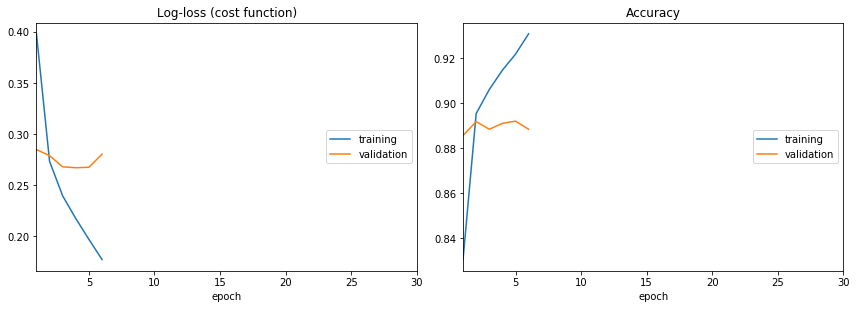

Log-loss (cost function):
training   (min:    0.177, max:    0.398, cur:    0.177)
validation (min:    0.267, max:    0.285, cur:    0.280)

Accuracy:
training   (min:    0.831, max:    0.931, cur:    0.931)
validation (min:    0.886, max:    0.892, cur:    0.888)
25000/25000 [==============================] - 2s 74us/step
Test set accuracy: 0.87372


In [19]:
model = train_and_eval_mlp(x, labels, layers=2, units=64)

We see that the test set accuracy is ~88%! This is a pretty good result for this dataset, where the state-of-the-art is around 95%!

### Adjusting hyperparameters

We can try to change the hyperparameters of the network and see how that affects performance. This time, we'll use 3 layers instead of 2, and 16 hidden units instead of 64. We'll also increase the "dropout" rate, which is a fraction used to reduce overfitting in the model.

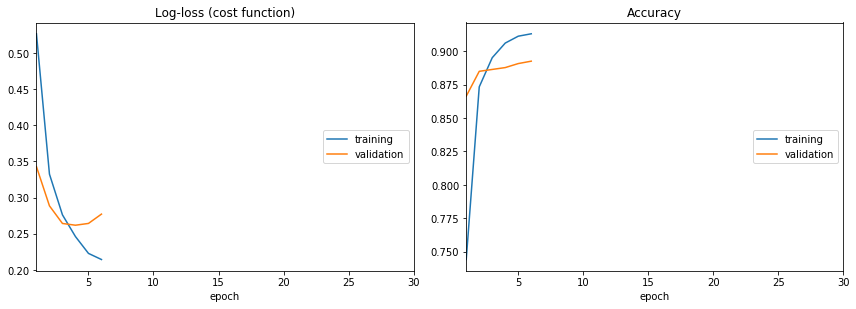

Log-loss (cost function):
training   (min:    0.214, max:    0.527, cur:    0.214)
validation (min:    0.262, max:    0.343, cur:    0.277)

Accuracy:
training   (min:    0.744, max:    0.913, cur:    0.913)
validation (min:    0.866, max:    0.893, cur:    0.893)
25000/25000 [==============================] - 1s 58us/step
Test set accuracy: 0.88188


In [20]:
model = train_and_eval_mlp(x, labels, layers=3, units=16, dropout_rate=0.5)

## Advanced: tf-idf vectorization instead of simple counts

One problem with the simple word counting done by `CountVectorizer` is that there are often common words that occur across documents ("a", "the", "of") in large frequencies. These tokens aren't particularly unique to the dataset, and don't help much with learning. The vectorizer should ideally penalize such high-frequency tokens so that they don't have a high token count in comparison to more meaningful words ("exceptional", "great", "bad").

To account for this, we can use `TfidfVectorizer`, which uses **tf-idf** scores for each token. tf-idf stands for "term frequency-inverse document frequency", which proportionally reduces the count (term frequency) of a token by the number of "documents" (in this case, reviews) that it has been seen in. Effectively, this score is penalizing tokens that are too common across the dataset, and giving high scores to "meaningful" tokens.

As an example, let's go back to our toy dataset, and compare what `CountVectorizer` and `TfidfVectorizer` produce.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

simple_count_vectorizer = CountVectorizer()
simple_tfidf_vectorizer = TfidfVectorizer()

simple_dataset = [
    'This is a terrible terrible and disappointing movie.',
    'This is something worth spending on.',
    'Is this a movie I recommend? No.',
    'Some "movie".',
]

X_with_count = simple_count_vectorizer.fit_transform(simple_dataset)
X_with_tfidf = simple_tfidf_vectorizer.fit_transform(simple_dataset)
X_with_tfidf.toarray()

array([[0.37210398, 0.37210398, 0.23750915, 0.23750915, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.74420795, 0.23750915, 0.        ],
       [0.        , 0.        , 0.29088811, 0.        , 0.        ,
        0.45573244, 0.        , 0.        , 0.45573244, 0.45573244,
        0.        , 0.29088811, 0.45573244],
       [0.        , 0.        , 0.3555803 , 0.3555803 , 0.55708525,
        0.        , 0.55708525, 0.        , 0.        , 0.        ,
        0.        , 0.3555803 , 0.        ],
       [0.        , 0.        , 0.        , 0.53802897, 0.        ,
        0.        , 0.        , 0.84292635, 0.        , 0.        ,
        0.        , 0.        , 0.        ]])

Instead of simple counts, now the vectorizer produces fractions, which indicate that we're now doing some kind of weighting.

The real difference, though, is in observing the values produced for certain features across samples. For example, here are the feature values produced by the count and tf-idf vectorizers for the features corresponding to "is" and "recommend":

In [22]:
print("Values for 'is' with count vectorizer: ",
      X_with_count.toarray()[:, simple_vectorizer.vocabulary_["is"]])
print("Values for 'recommend' with count vectorizer: ",
      X_with_count.toarray()[:, simple_vectorizer.vocabulary_["recommend"]])
print("Values for 'is' with count vectorizer: ",
      X_with_tfidf.toarray()[:, simple_vectorizer.vocabulary_["is"]])
print("Values for 'recommend' with tf-idf vectorizer: ",
      X_with_tfidf.toarray()[:, simple_vectorizer.vocabulary_["recommend"]])

Values for 'is' with count vectorizer:  [1 1 1 0]
Values for 'recommend' with count vectorizer:  [0 0 1 0]
Values for 'is' with count vectorizer:  [0.23750915 0.29088811 0.3555803  0.        ]
Values for 'recommend' with tf-idf vectorizer:  [0.         0.         0.55708525 0.        ]


As we can see, the `CountVectorizer` doesn't treat the two features really differently, while the `TfidfVectorizer` gives lower values to features that are less "interesting".

### Training a model with tf-idf vectorizer

Let's build a new vectorizer that does tf-idf weighting. This time, let's also include bigrams in our input features.

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),      # Use unigrams and bigrams
                                   strip_accents='unicode', # remove accented characters
                                   decode_error='replace',  # replace un-decodeable characters
                                   min_df=2) # discard tokens that appear in fewer than two samples/reviews
x_2 = vectorize(data, labels, tfidf_vectorizer)

Then, let's try training the MLP again with this new vectorized dataset (we might have to adjust hyperparameters a few times to learn something effective).

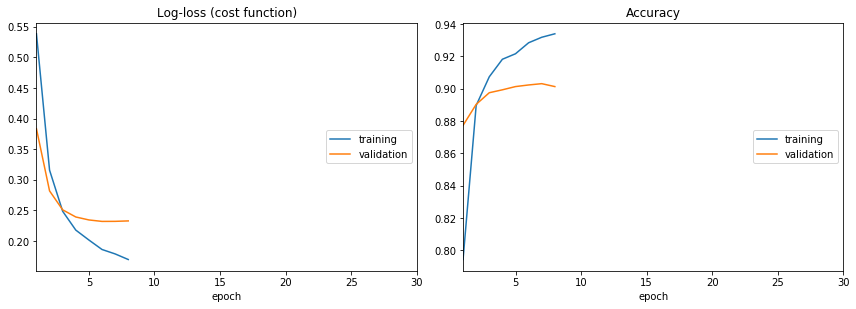

Log-loss (cost function):
training   (min:    0.170, max:    0.538, cur:    0.170)
validation (min:    0.232, max:    0.383, cur:    0.233)

Accuracy:
training   (min:    0.794, max:    0.934, cur:    0.934)
validation (min:    0.877, max:    0.903, cur:    0.901)
25000/25000 [==============================] - 2s 73us/step
Test set accuracy: 0.90164


In [24]:
model = train_and_eval_mlp(x_2, labels, layers=2, units=64, dropout_rate=0.2)

We should be able to get an accuracy of 90% with a little trial and error, reflecting a 2% increase over our previous model, and only 5% lower than state-of-the-art!